In [1]:
# Install necessary libraries
!pip install transformers lime Pillow wget matplotlib numpy scikit-image


In [2]:
!pip install lime --upgrade

In [3]:
#Clear Cached Images
!rm sample_image.jpg

In [4]:
# Download a sample image from the web using wget
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Covid_Vaccine_Alters_DNA_Forever_graffito_with_%22Will_it_make_me_an_X-Men%22_addendum%2C_pole%2C_Studio_City%2C_Los_Angeles%2C_California%2C_USA_-_Flickr_-_gruntzooki.jpg/640px-Covid_Vaccine_Alters_DNA_Forever_graffito_with_%22Will_it_make_me_an_X-Men%22_addendum%2C_pole%2C_Studio_City%2C_Los_Angeles%2C_California%2C_USA_-_Flickr_-_gruntzooki.jpg -O sample_image.jpg

--2024-10-02 16:58:51--  https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/Covid_Vaccine_Alters_DNA_Forever_graffito_with_%22Will_it_make_me_an_X-Men%22_addendum%2C_pole%2C_Studio_City%2C_Los_Angeles%2C_California%2C_USA_-_Flickr_-_gruntzooki.jpg/640px-Covid_Vaccine_Alters_DNA_Forever_graffito_with_%22Will_it_make_me_an_X-Men%22_addendum%2C_pole%2C_Studio_City%2C_Los_Angeles%2C_California%2C_USA_-_Flickr_-_gruntzooki.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167757 (164K) [image/jpeg]
Saving to: ‘sample_image.jpg’

sample_image.jpg    100%[===================>] 163.83K  --.-KB/s    in 0.08s   

2024-10-02 16:58:51 (1.95 MB/s) - ‘sample_image.jpg’ saved [167757/167757]



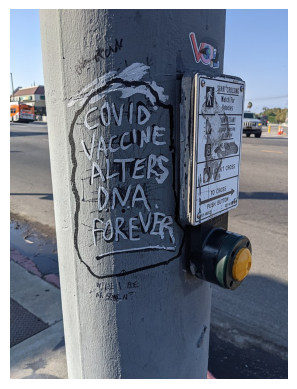

In [12]:
#Verify that the image is updated
from PIL import Image
import matplotlib.pyplot as plt

# Open the downloaded image and display it
img = Image.open('sample_image.jpg')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [6]:
# Necessary imports
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from lime.lime_image import LimeImageExplainer
from lime.lime_text import LimeTextExplainer
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


In [7]:
# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Set the model to evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [8]:
# Load and preprocess the image
input_image = Image.open("sample_image.jpg")
input_image_np = np.array(input_image)

# Example input text (replace with your own text)
input_text = "Sharks in Floodwaters"

# Process the inputs (both image and text)
inputs = processor(text=input_text, images=input_image, return_tensors="pt", padding=True)

In [9]:
# Make predictions using the CLIP model
with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Image-text similarity scores
    probs = logits_per_image.softmax(dim=1).cpu().numpy()  # Convert to probabilities

# Output predicted probabilities
print("Predicted probabilities:", probs)

Predicted probabilities: [[1.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

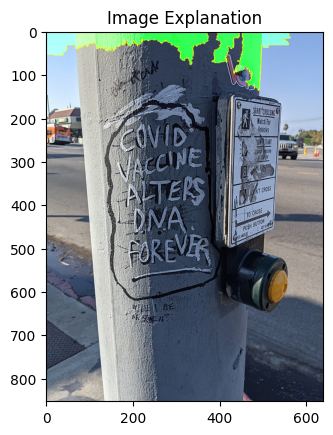

In [10]:
# Initialize LIMEImageExplainer
explainer_image = LimeImageExplainer()

# Define a function to predict probabilities for the image and text
def predict_image_fn(images):
    # You need to specify text along with the image for the CLIP model
    input_texts = ["Sharks in Floodwaters"] * len(images)  # Sample text
    inputs = processor(text=input_texts, images=images, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image  # Logits for images
        probs = logits_per_image.softmax(dim=1).cpu().numpy()  # Convert to probabilities

    return probs

# Process the image using numpy array
input_image = Image.open("sample_image.jpg")  # Load the sample image
input_image_np = np.array(input_image)

# Explain the image
explanation_image = explainer_image.explain_instance(
    input_image_np,
    predict_image_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get the image explanation
temp, mask = explanation_image.get_image_and_mask(
    explanation_image.top_labels[0],
    positive_only=False,
    num_features=10,
    hide_rest=False
)

# Display the explanation
plt.imshow(mark_boundaries(temp, mask))
plt.title("Image Explanation")
plt.show()

In [11]:
# ---- LIME for Text Explanation ----

# Initialize LIMETextExplainer
explainer_text = LimeTextExplainer(class_names=['Fake', 'Real'])

# Define a function to predict probabilities for the text
def predict_text_fn(texts):
    input_images = [input_image] * len(texts)  # Use the same image for all text inputs
    inputs = processor(text=texts, images=input_images, return_tensors="pt", padding=True)

    with torch.no_grad():
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1).cpu().numpy()

    return probs

# Explain the text
explanation_text = explainer_text.explain_instance(
    input_text,
    predict_text_fn,
    num_features=6
)

# Display the text explanation in the notebook
explanation_text.show_in_notebook(text=True)

# Alternatively, print an explanation summary
print(explanation_text.as_list())  # This will print the list of important text features

[('Floodwaters', 1.993717549639531e-15), ('Sharks', 1.300757434972477e-15), ('in', 4.1141947960045436e-16)]
